In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
import pickle

In [67]:
x_train = pd.read_csv('x_train.csv')
x_test = pd.read_csv('x_test.csv')
y_train = pd.read_csv('y_train.csv')['class']
y_test = pd.read_csv('y_test.csv')['class']

In [19]:
# data is imbalanced, will have to resort to either optimizing class weigths or SMOTE 

## FEATURE CORRELATIONS

Text(0.5, 1.0, 'Feature correlations')

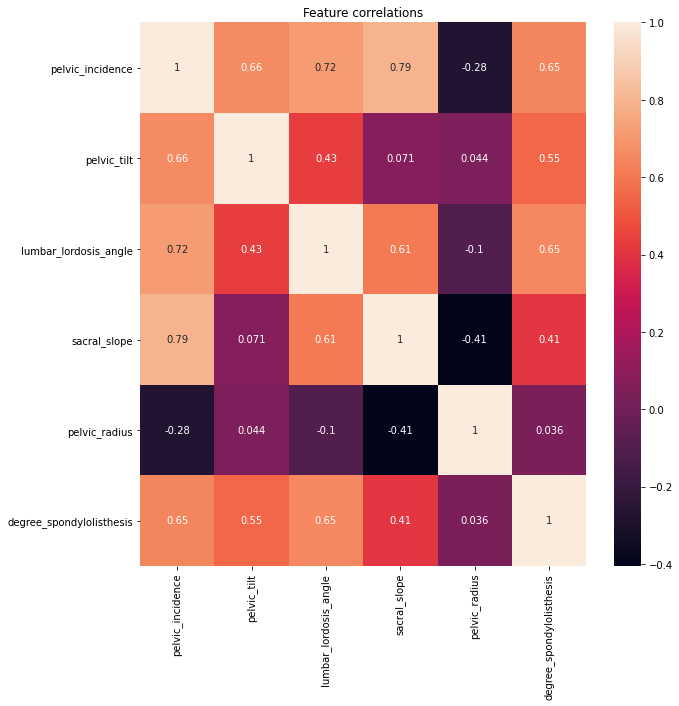

In [34]:
corr = sns.heatmap(x_train.corr(), annot = True)
plt.title('Feature correlations')

### sacral_slope and pelvic_incidence have a slightly high correlation of 0.79
#### But none of the correlations is extensively high and so no features are removed

## Feature distributions

In [41]:
def plot_hist(data):
    for col in data:
        plt.hist(data[col])
        plt.title(col)
        plt.savefig(f'charts/{col}.jpg')
        plt.figure()
plt.rcParams["figure.figsize"] = (5,5)

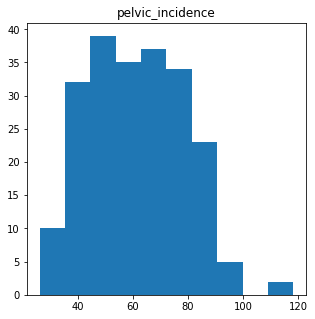

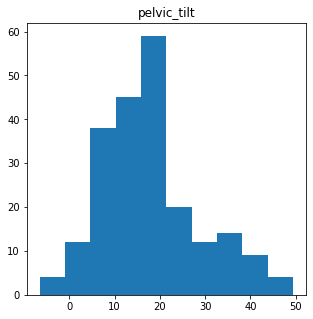

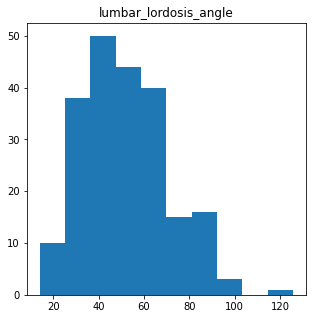

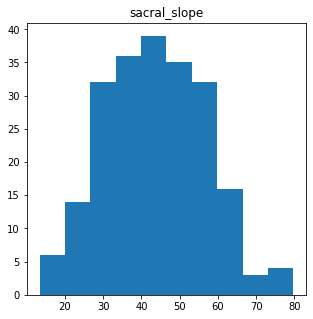

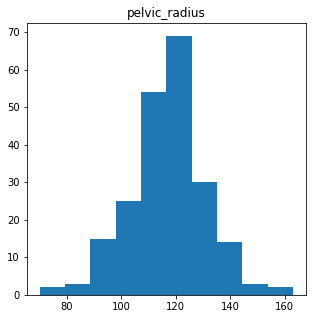

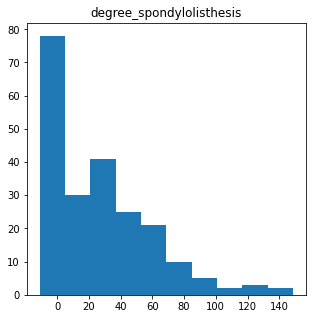

<Figure size 360x360 with 0 Axes>

In [42]:
plot_hist(x_train)

### most features seems to have gaussian like distribution except for degree_spondylolisthesis

### pelvic_incidence and lumbar_lordosis_angle do seem to have some outlier values to the far right as well

### simple standard scaling of the features should be suffient

### robust scaling can be tried out on pelvic_incidence ,lumbar_lordosis and degree_spondylolisthesis 


## Defining the metrics
### using recall and precision for each class

In [193]:
def prec_0(y_true, y_pred):
    mask_true = (y_true == 0)
    mask_pred = (y_pred == 0)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_pred).sum()

def rec_0(y_true, y_pred):
    mask_true = (y_true == 0)
    mask_pred = (y_pred == 0)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_true).sum()

def prec_1(y_true, y_pred):
    mask_true = (y_true == 1)
    mask_pred = (y_pred == 1)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_pred).sum()

def rec_1(y_true, y_pred):
    mask_true = (y_true == 1)
    mask_pred = (y_pred == 1)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_true).sum()

def prec_2(y_true, y_pred):
    mask_true = (y_true == 2)
    mask_pred = (y_pred == 2)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_pred).sum()

def rec_2(y_true, y_pred):
    mask_true = (y_true == 2)
    mask_pred = (y_pred == 2)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_true).sum()

def eval_score(y_true, y_pred):
    scores = {'prec_0':prec_0(y_true, y_pred),
              'rec_0':rec_0(y_true, y_pred),
              'prec_1':prec_1(y_true, y_pred),
              'rec_1':rec_1(y_true, y_pred),
              'prec_2':prec_2(y_true, y_pred),
              'rec_2':rec_2(y_true, y_pred)}
    return scores

In [154]:
scores = {'prec_0':make_scorer(prec_0),
          'rec_0':make_scorer(rec_0),
          'prec_1':make_scorer(prec_1),
          'rec_1':make_scorer(rec_1),
          'prec_2':make_scorer(prec_2),
          'rec_2':make_scorer(rec_2)}

### Logistic Regression with Standard scaling

In [155]:
pipe_lr = Pipeline([('transformer', StandardScaler()),
                 ('model', LogisticRegression())])

### since there are less sample of disk hernia in the dataset, we need to find the optmial class weight for it
### also have to figure out the optimal regularization strength

In [181]:
grid_lr = GridSearchCV(estimator = pipe_lr, 
                      param_grid = {'model__class_weight':[{0:1, 1:1, 2:i} for i in np.linspace(1, 3, 20)]},
                      scoring = scores,
                      n_jobs = -1,
                      refit = 'prec_1',
                      return_train_score = True,
                      cv = 6)

In [182]:
grid_lr.fit(x_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('transformer', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__class_weight': [{0: 1, 1: 1, 2: 1.0},
                                                 {0: 1, 1: 1,
                                                  2: 1.1052631578947367},
                                                 {0: 1, 1: 1,
                                                  2: 1.2105263157894737},
                                                 {0: 1, 1: 1,
                                                  2: 1.3157894736842106},
                                                 {0: 1, 1: 1,
                                                  2: 1.4210526315789473},
                                                 {0: 1, 1: 1,
                                                  2: 1.526315789473684},
                                                 {0: 1, 1: 

In [183]:
result_lr = pd.DataFrame(grid_lr.cv_results_)

In [184]:
result_lr.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__class_weight', 'params', 'split0_test_prec_0',
       'split1_test_prec_0', 'split2_test_prec_0', 'split3_test_prec_0',
       ...
       'std_test_rec_2', 'rank_test_rec_2', 'split0_train_rec_2',
       'split1_train_rec_2', 'split2_train_rec_2', 'split3_train_rec_2',
       'split4_train_rec_2', 'split5_train_rec_2', 'mean_train_rec_2',
       'std_train_rec_2'],
      dtype='object', length=108)

In [213]:
def plot(result, x, cols, title, x_label, y_label, param, model_name, address):
    for col in cols:
        plt.plot(x, result[f'mean_train_{col}'], label = f'{col}_train', linestyle = '--', marker = 'o')
        plt.plot(x, result[f'mean_test_{col}'], label = f'{col}_test')
        plt.title(f'{title}/{col}')
        plt.legend()
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.savefig(f'charts/{model_name}/{address}_{param}_{col}.jpg')
        plt.figure()
        
    
    
    

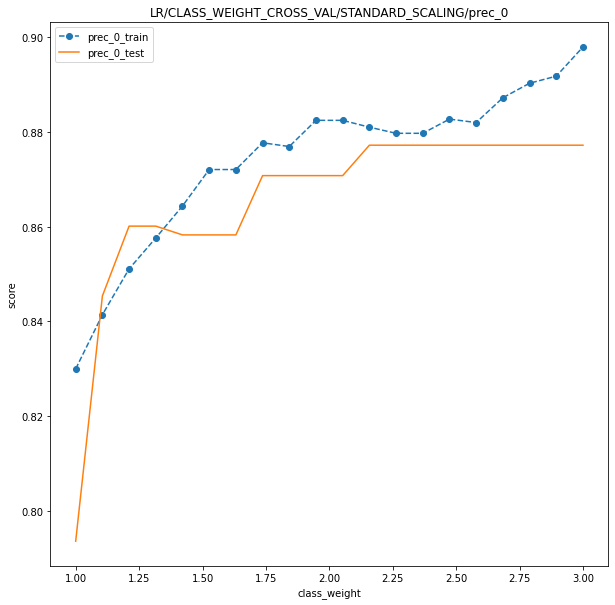

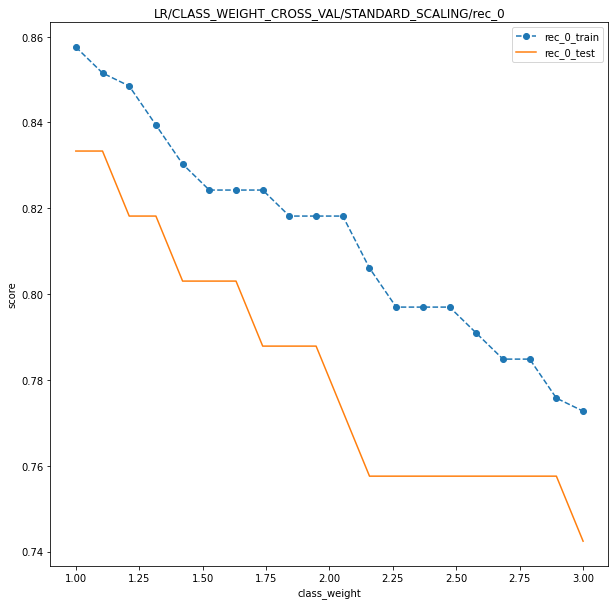

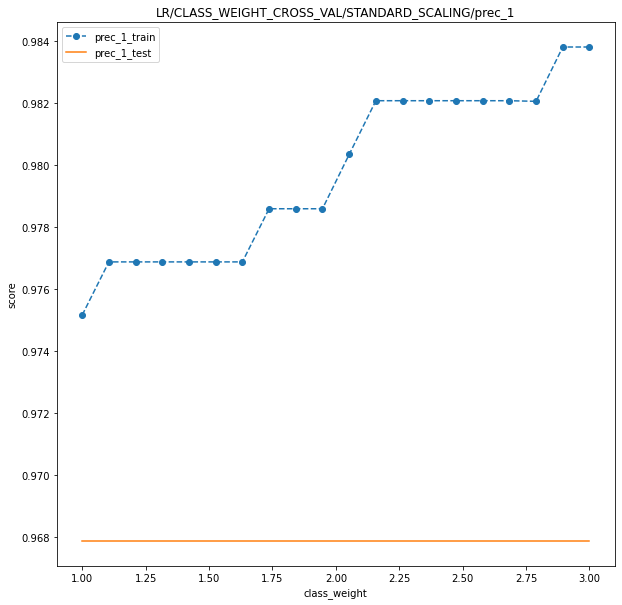

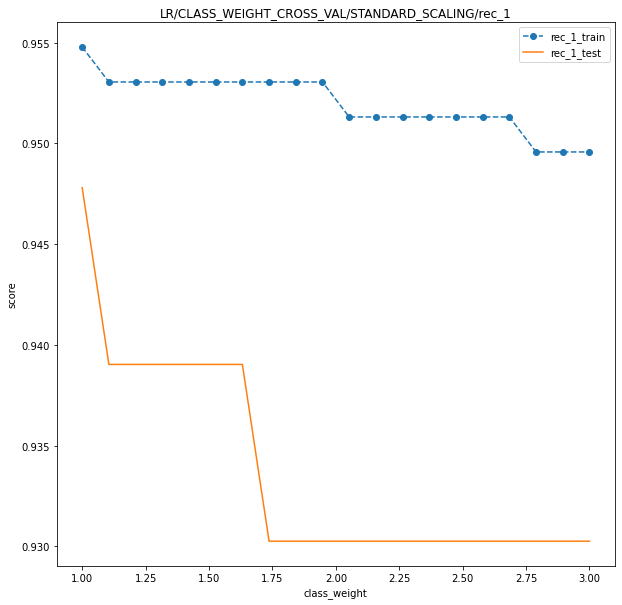

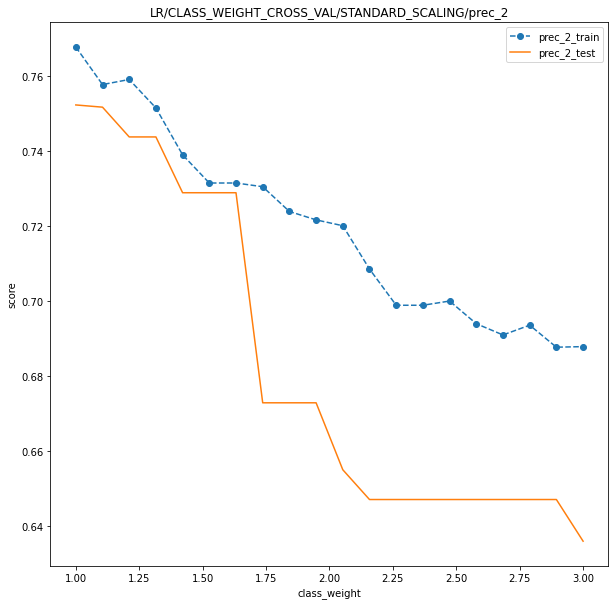

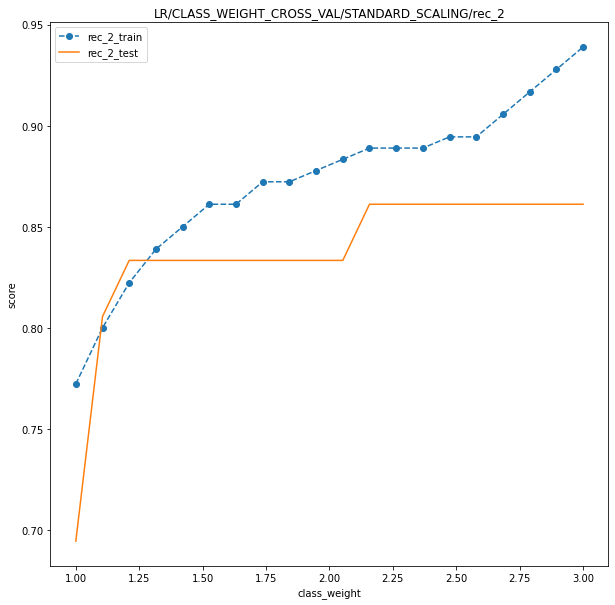

<Figure size 720x720 with 0 Axes>

In [186]:
plot(result_lr, np.linspace(1, 3, 20), list(scores.keys()),'LR/CLASS_WEIGHT_CROSS_VAL/STANDARD_SCALING', 'class_weight', 'score', 'class_weight')

## Observation
With increasing class weight of Disk Hernia ,

Precision of Normal is increasing, Spondylolisthesis is unaffected and decreases for Disk Hernia

Recall of Disk Hernia increases , but decreases for the other 2 classes

Recall of Spondylolisthesis only drops from 94.5% to 93%, where as recall of Disk Hernia increase from 70 % to 85 %


### A sensible choice for class weight of Disk Hernia seems to be 2.25



In [174]:
# a new pipeline with class weight of disk hernia as 2.5

In [177]:
pipe_new = Pipeline([('transformer', StandardScaler()),
                     ('model', LogisticRegression(class_weight = {0:1, 1:1, 2:2.25}))])

In [187]:
grid_new = GridSearchCV(estimator = pipe_new,
                       param_grid = {'model__C':np.linspace(0.1, 5, 50)},
                       scoring = scores, 
                       refit = 'prec_1',
                       n_jobs = -1,
                       cv = 6,
                       return_train_score = True)

In [188]:
grid_new.fit(x_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('transformer', StandardScaler()),
                                       ('model',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 1,
                                                                         2: 2.25}))]),
             n_jobs=-1,
             param_grid={'model__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])},
             refit='prec_1', return_train_score=True,
             scoring={'prec_0': make_scorer(prec_0),
                      'prec_1': make_scorer(prec_1),
                      'prec_2': make_scorer(prec_2),
                      'rec_0': make_scorer(rec_0), 'rec_1'

In [189]:
result_new = pd.DataFrame(grid_new.cv_results_)

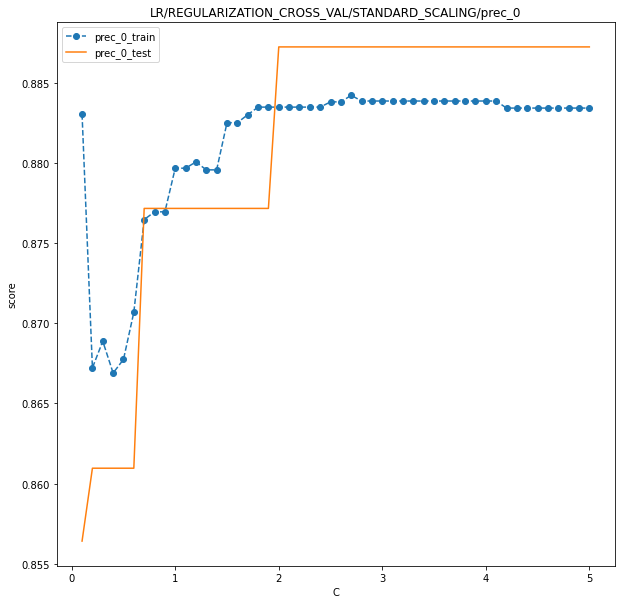

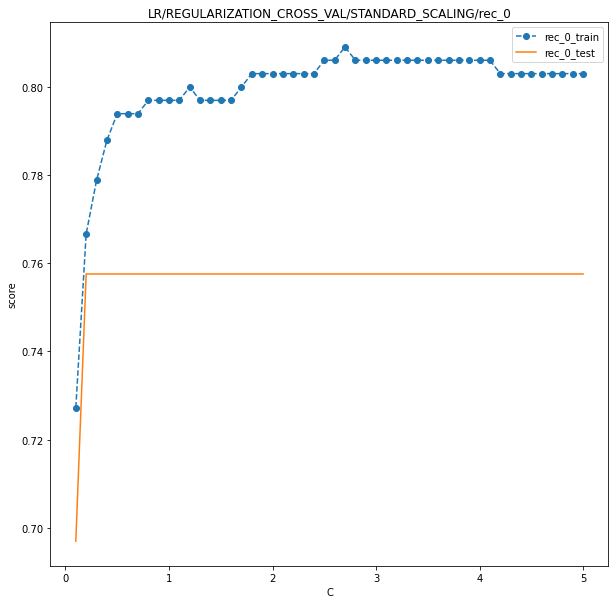

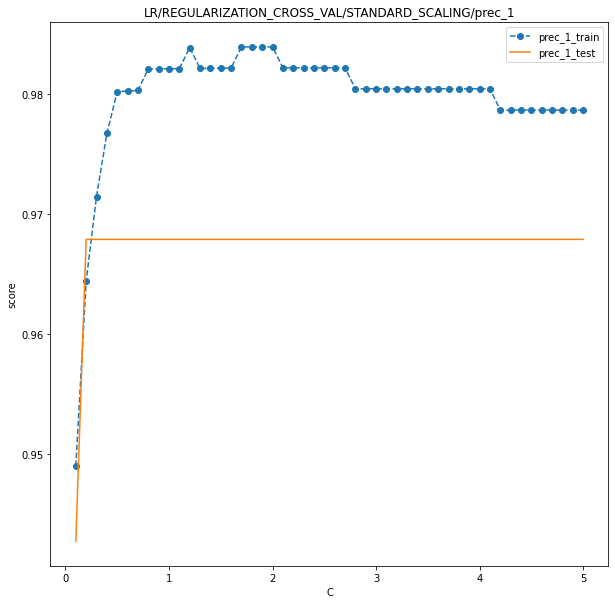

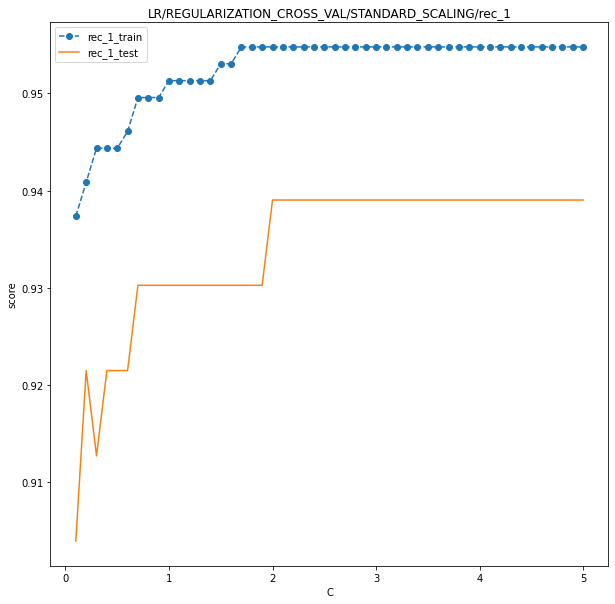

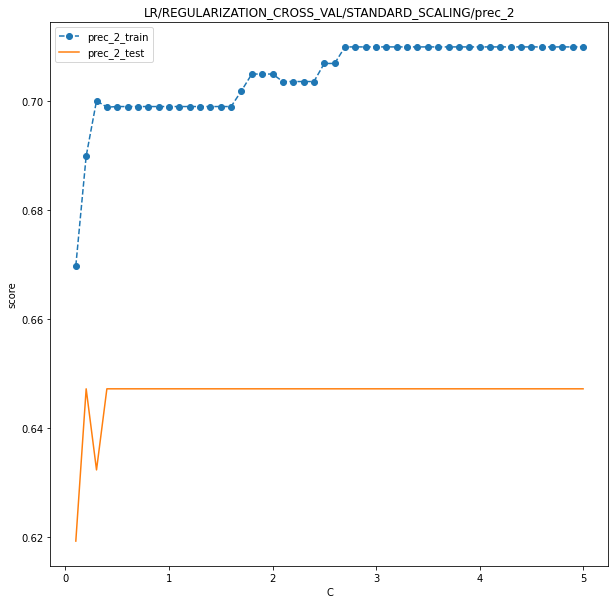

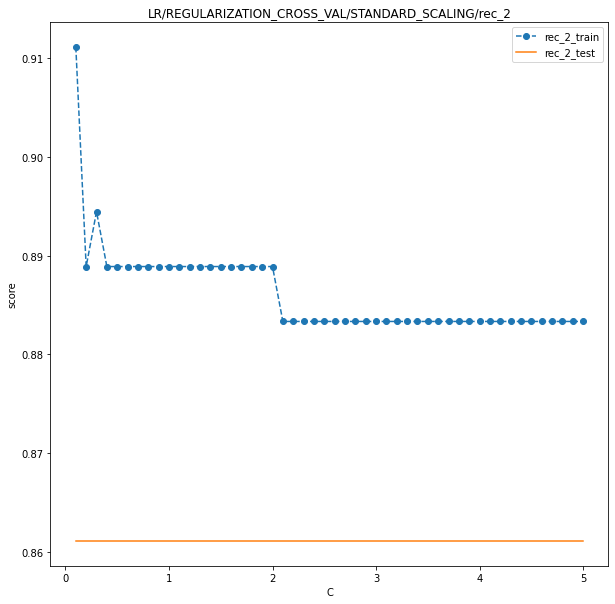

<Figure size 720x720 with 0 Axes>

In [190]:
plot(result_new, np.linspace(0.1, 5, 50), list(scores.keys()), 'LR/REGULARIZATION_CROSS_VAL/STANDARD_SCALING', 'C', 'score', 'regularization')

## Observation
All the metrics are incresing , with increasing regularization except for Disk Hernia Recall which remains unchanged.

### Hence a sensible choice for Regularization Strength is 3

In [200]:
pipe_final_lr = Pipeline([('transformer', StandardScaler()),
                          ('model', LogisticRegression(class_weight = {0:1, 1:1, 2:2.25}, C = 3))])

In [201]:
pipe_final_lr.fit(x_train, y_train)

Pipeline(steps=[('transformer', StandardScaler()),
                ('model',
                 LogisticRegression(C=3, class_weight={0: 1, 1: 1, 2: 2.25}))])

In [202]:
eval_score(y_train, pipe_final_lr.predict(x_train))

{'prec_0': 0.8852459016393442,
 'rec_0': 0.8181818181818182,
 'prec_1': 0.9821428571428571,
 'rec_1': 0.9565217391304348,
 'prec_2': 0.7045454545454546,
 'rec_2': 0.8611111111111112}

In [203]:
eval_score(y_test, pipe_final_lr.predict(x_test))

{'prec_0': 0.7058823529411765,
 'rec_0': 0.7058823529411765,
 'prec_1': 0.9444444444444444,
 'rec_1': 0.9714285714285714,
 'prec_2': 0.6086956521739131,
 'rec_2': 0.5833333333333334}

## Testing Performance of LogisticRegression Model

#### Normal Precision : 0.705
#### Normal Recall : 0.705
#### Spondylolisthesis Precision : 0.94
#### Spondylolisthesis Recall : 0.971
#### Hernia Precision : 0.608
#### Hernia Recall : 0.583

### Now using Robust Scaler

In [205]:
robust_pipe = Pipeline([('transformer', RobustScaler()),
                        ('model', LogisticRegression())])

In [207]:
grid_robust = GridSearchCV(estimator = robust_pipe,
                          param_grid = {'model__class_weight':[{0:1,1:1,2:i} for i in np.linspace(1, 3, 20)]},
                          scoring = scores,
                           n_jobs = -1,
                           refit = 'prec_0',
                           cv = 6,
                           return_train_score = True,
                          )

In [208]:
grid_robust.fit(x_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('transformer', RobustScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__class_weight': [{0: 1, 1: 1, 2: 1.0},
                                                 {0: 1, 1: 1,
                                                  2: 1.1052631578947367},
                                                 {0: 1, 1: 1,
                                                  2: 1.2105263157894737},
                                                 {0: 1, 1: 1,
                                                  2: 1.3157894736842106},
                                                 {0: 1, 1: 1,
                                                  2: 1.4210526315789473},
                                                 {0: 1, 1: 1,
                                                  2: 1.526315789473684},
                                                 {0: 1, 1: 1,

In [209]:
robust_result = pd.DataFrame(grid_robust.cv_results_)

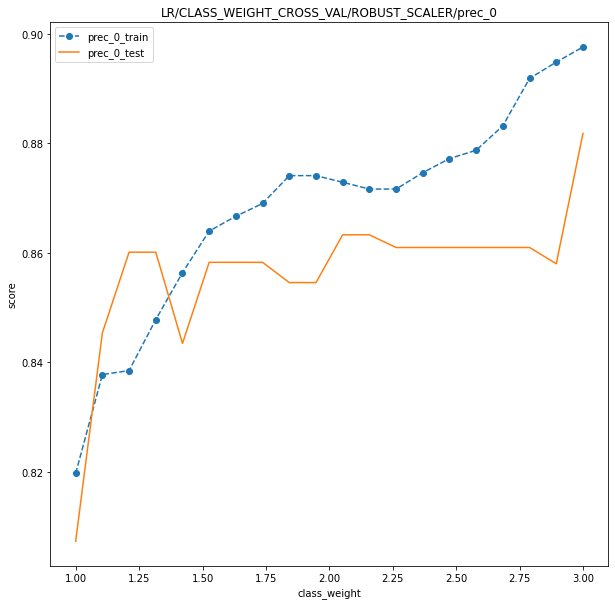

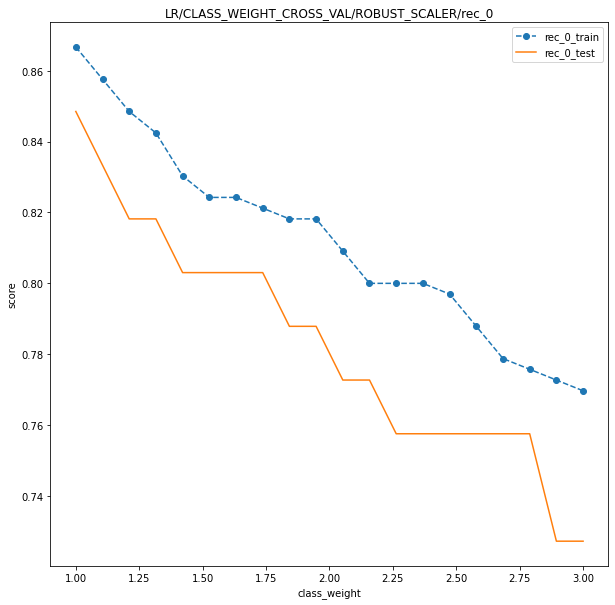

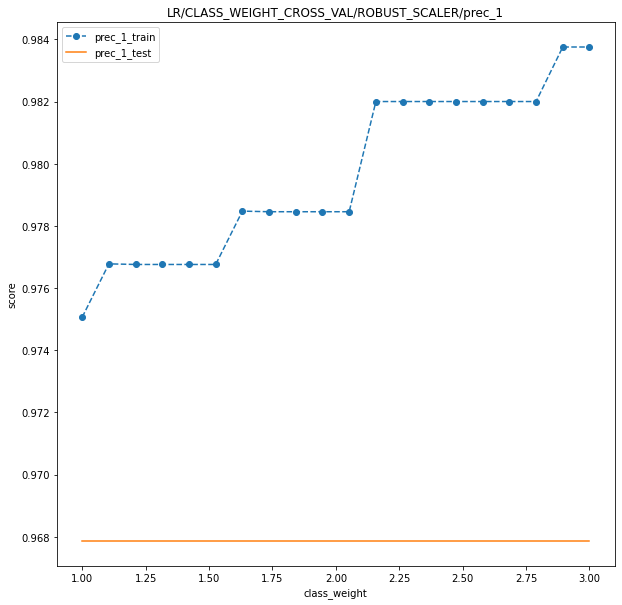

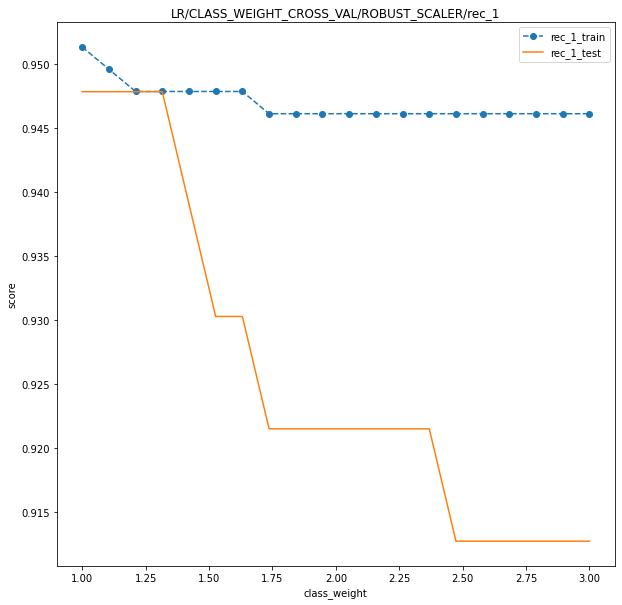

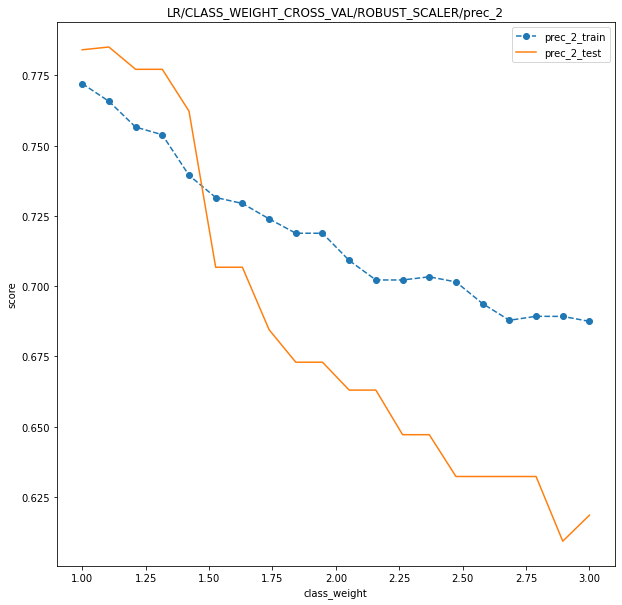

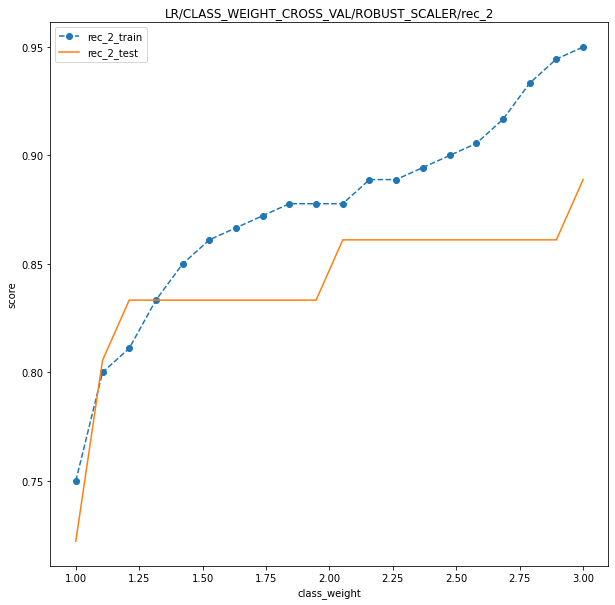

<Figure size 720x720 with 0 Axes>

In [214]:
plot(robust_result, np.linspace(1, 3, 20), list(scores.keys()),'LR/CLASS_WEIGHT_CROSS_VAL/ROBUST_SCALER', 'class_weight', 'score', 'class_weight', 'logisticRegression','RobustScaling')

## Observation 

### Precision of both Normal and Spondylolisthesis increase with class weight, where as it falls for Disk Hernia
### Recall falls for Normal and Spondylolisthesis and increases for Disk Hernia

### A sensible choice for class weight seems to be 2.25

In [215]:
robust_pipe_new = Pipeline([('transformer',RobustScaler()),
                            ('model', LogisticRegression(class_weight = {0:1, 1:1, 2:2.25}))])

In [216]:
grid_new_robust = GridSearchCV(estimator = robust_pipe_new,
                              param_grid = {'model__C':np.linspace(0.1, 5, 50)},
                       scoring = scores, 
                       refit = 'prec_1',
                       n_jobs = -1,
                       cv = 6,
                       return_train_score = True)

In [217]:
grid_new_robust.fit(x_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('transformer', RobustScaler()),
                                       ('model',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 1,
                                                                         2: 2.25}))]),
             n_jobs=-1,
             param_grid={'model__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])},
             refit='prec_1', return_train_score=True,
             scoring={'prec_0': make_scorer(prec_0),
                      'prec_1': make_scorer(prec_1),
                      'prec_2': make_scorer(prec_2),
                      'rec_0': make_scorer(rec_0), 'rec_1': 

In [218]:
new_robust_result = pd.DataFrame(grid_new_robust.cv_results_)

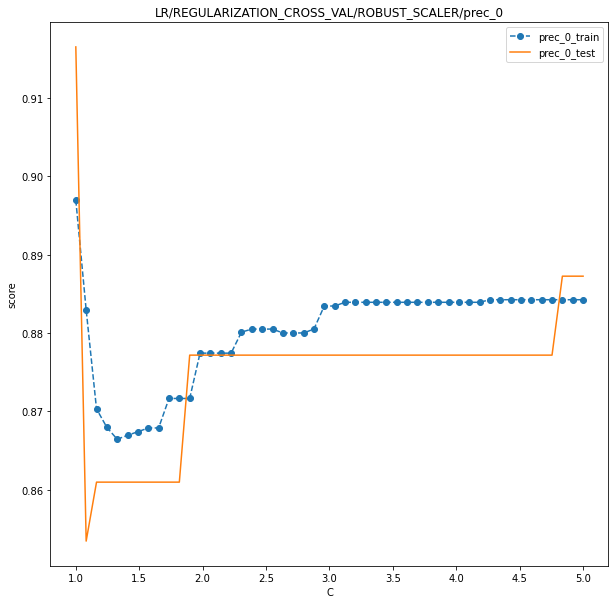

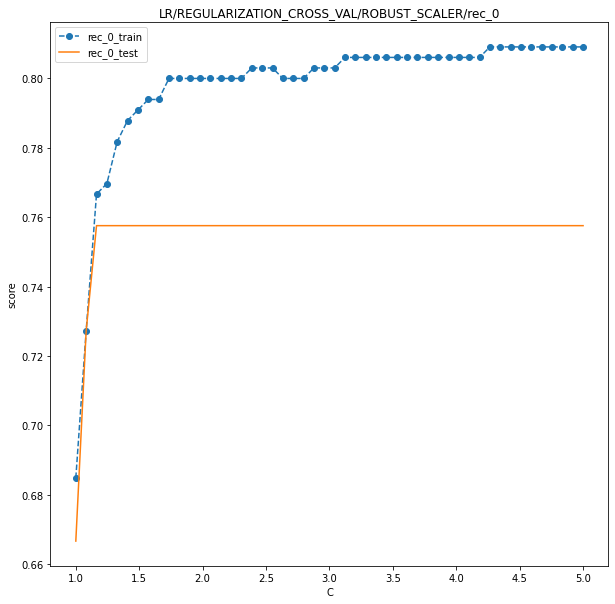

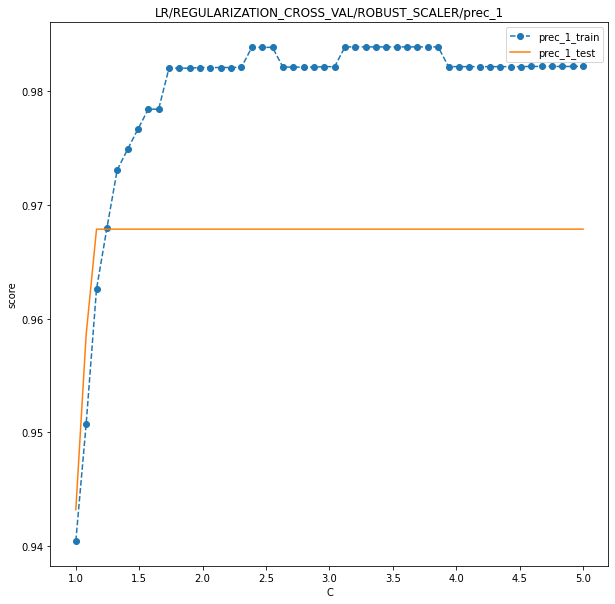

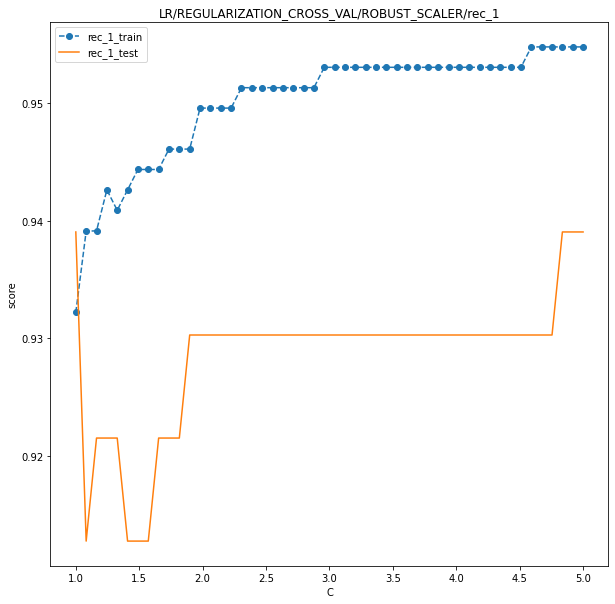

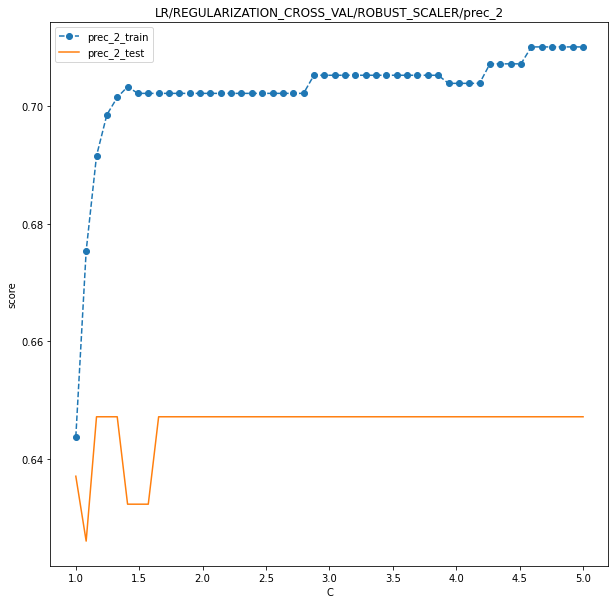

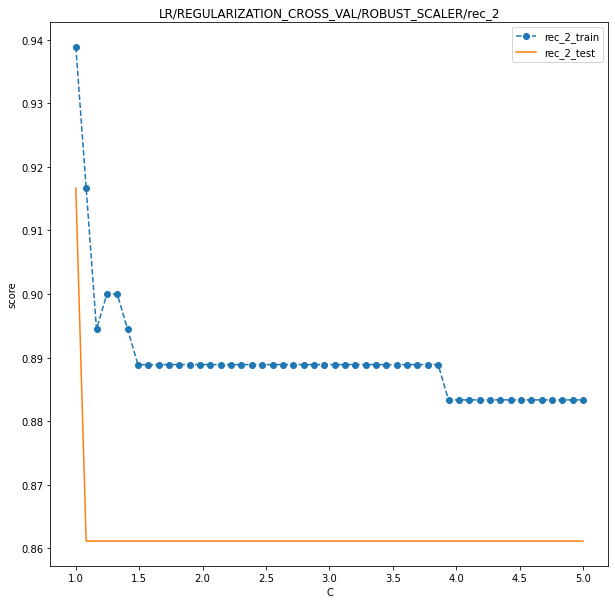

<Figure size 720x720 with 0 Axes>

In [220]:
plot(new_robust_result, np.linspace(1, 5, 50), list(scores.keys()),'LR/REGULARIZATION_CROSS_VAL/ROBUST_SCALER', 'C', 'score', 'C', 'logisticRegression','RobustScaling')

## regularization of 1 seems a good choice

In [224]:
new_pipe_robust = Pipeline([('transformer', RobustScaler()),
                             ('model', LogisticRegression(class_weight = {0:1, 1:1, 2:2.25}, C = 1))])

In [225]:
new_pipe_robust.fit(x_train, y_train)

Pipeline(steps=[('transformer', RobustScaler()),
                ('model',
                 LogisticRegression(C=1, class_weight={0: 1, 1: 1, 2: 2.25}))])

In [226]:
eval_score(y_train, new_pipe_robust.predict(x_train))

{'prec_0': 0.8688524590163934,
 'rec_0': 0.803030303030303,
 'prec_1': 0.9819819819819819,
 'rec_1': 0.9478260869565217,
 'prec_2': 0.7111111111111111,
 'rec_2': 0.8888888888888888}

In [227]:
eval_score(y_test, new_pipe_robust.predict(x_test))

{'prec_0': 0.7272727272727273,
 'rec_0': 0.7058823529411765,
 'prec_1': 0.9444444444444444,
 'rec_1': 0.9714285714285714,
 'prec_2': 0.625,
 'rec_2': 0.625}

# LogisticRegression with RobustScaling Testing Performance

#### Normal Precision = 0.727
#### Normal Recall = 0.705
#### Spondylolisthesis Precision = 0.944
#### Spondylolisthesis Recall = 0.971
#### Disk Hernia Precision = 0.625
#### Disk Hernia Recall = 0.625

## Robust Scaling provided a slightly better model

### Now robust scaling only the features with some outliers, Standard Scaling the others

In [228]:
x_train.columns

Index(['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis'],
      dtype='object')

In [238]:
def create_column_transformer():
    ct = ColumnTransformer([('standard', StandardScaler(), ['pelvic_tilt', 'sacral_slope', 'pelvic_radius']),
                       ('robust', RobustScaler(), ['pelvic_incidence', 'lumbar_lordosis_angle', 'degree_spondylolisthesis'])],
                      remainder = 'drop')
    return ct
    



In [241]:
ct_pipe = Pipeline([('transformer', create_column_transformer()),
                    ('model', LogisticRegression())])

In [242]:
ct_grid = GridSearchCV(estimator = ct_pipe, 
                      param_grid = {'model__class_weight':[{0:1, 1:1, 2:i} for i in np.linspace(1, 3, 20)]},
                      n_jobs = -1,
                      scoring = scores,
                      refit = 'prec_0',
                      return_train_score = True)

In [243]:
ct_grid.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('standard',
                                                                         StandardScaler(),
                                                                         ['pelvic_tilt',
                                                                          'sacral_slope',
                                                                          'pelvic_radius']),
                                                                        ('robust',
                                                                         RobustScaler(),
                                                                         ['pelvic_incidence',
                                                                          'lumbar_lordosis_angle',
                                                                          'degree_spondylolisthesis'])])),
                         

In [244]:
ct_result = pd.DataFrame(ct_grid.cv_results_)

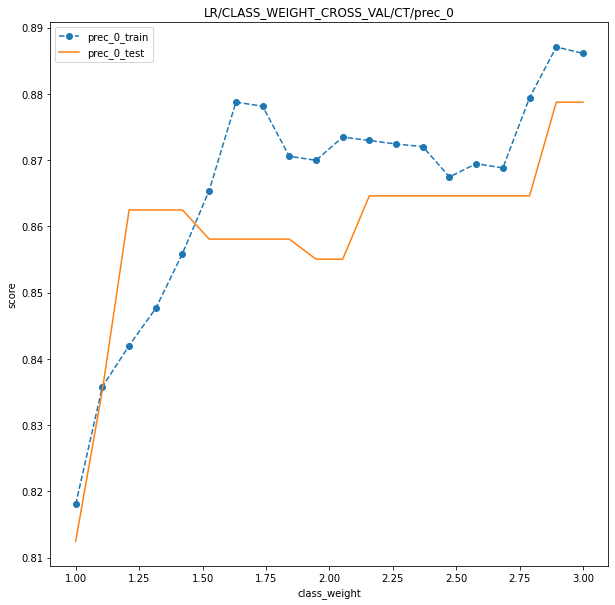

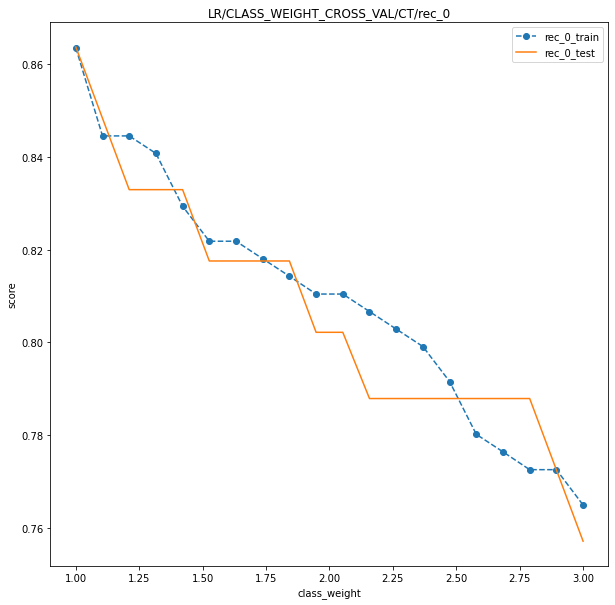

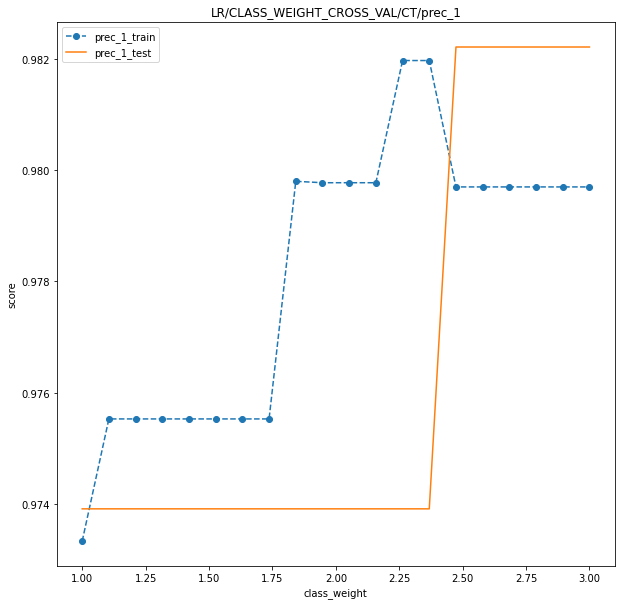

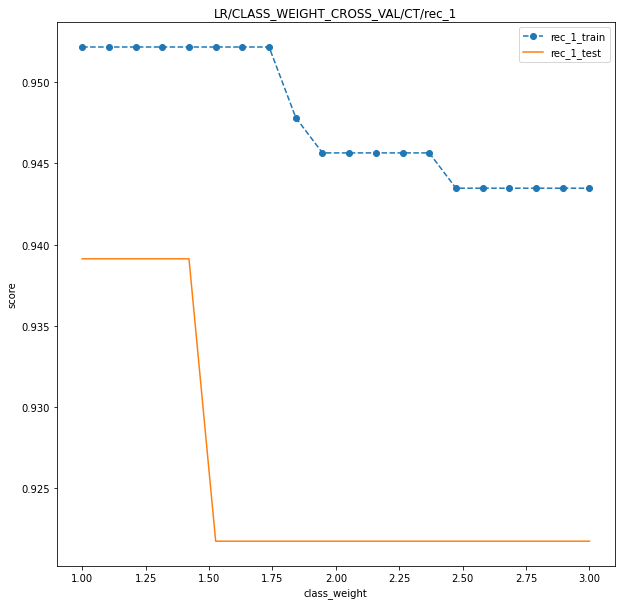

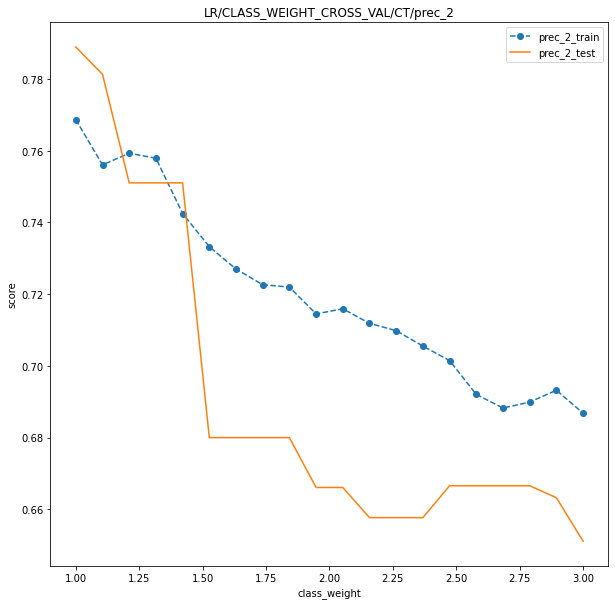

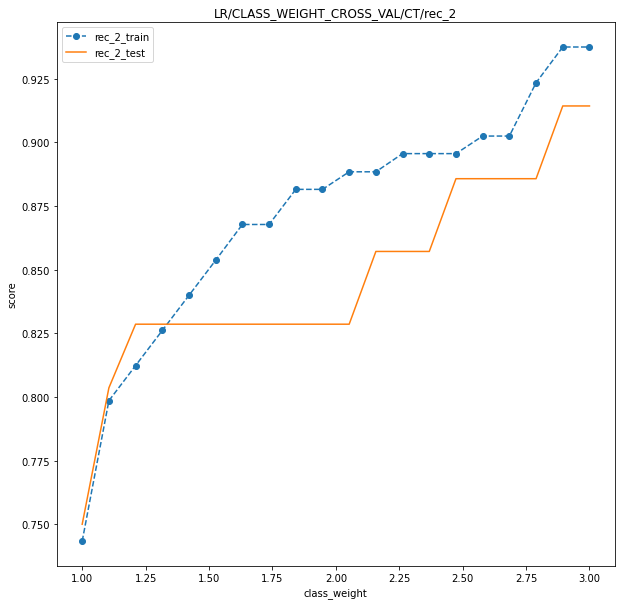

<Figure size 720x720 with 0 Axes>

In [245]:
plot(ct_result, np.linspace(1, 3, 20), list(scores.keys()),'LR/CLASS_WEIGHT_CROSS_VAL/CT', 'class_weight', 'score', 'class_weight', 'logisticRegression','CT')

## A reasonable choice seems like 2.75 for the class weight

In [247]:
ct_pipe_new = Pipeline([('transformer', create_column_transformer()),
                    ('model', LogisticRegression(class_weight = {0:1,1:1,2:2.75}))])

In [248]:
grid_new = GridSearchCV(estimator = ct_pipe_new, 
                       param_grid = {'model__C':np.linspace(1, 5, 50)},
                       scoring = scores, 
                       refit = 'prec_1',
                       n_jobs = -1,
                       cv = 6,
                       return_train_score = True)

In [249]:
grid_new.fit(x_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('standard',
                                                                         StandardScaler(),
                                                                         ['pelvic_tilt',
                                                                          'sacral_slope',
                                                                          'pelvic_radius']),
                                                                        ('robust',
                                                                         RobustScaler(),
                                                                         ['pelvic_incidence',
                                                                          'lumbar_lordosis_angle',
                                                                          'degree_spondylolisthesis'])])),
      

In [250]:
ct_new_result = pd.DataFrame(grid_new.cv_results_)

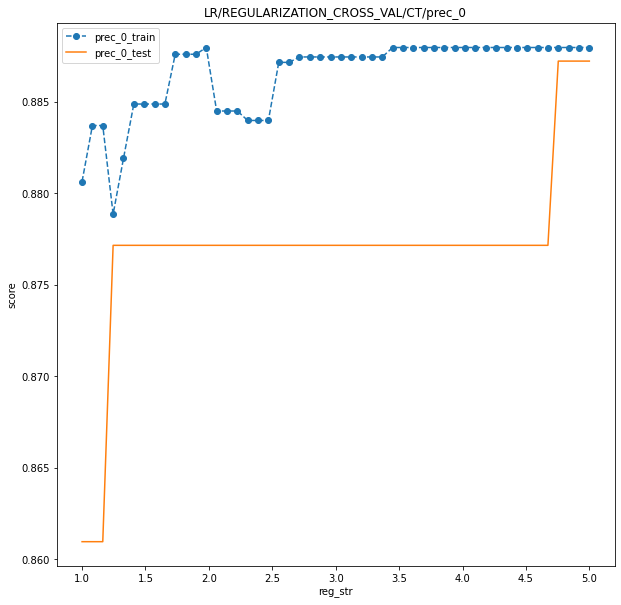

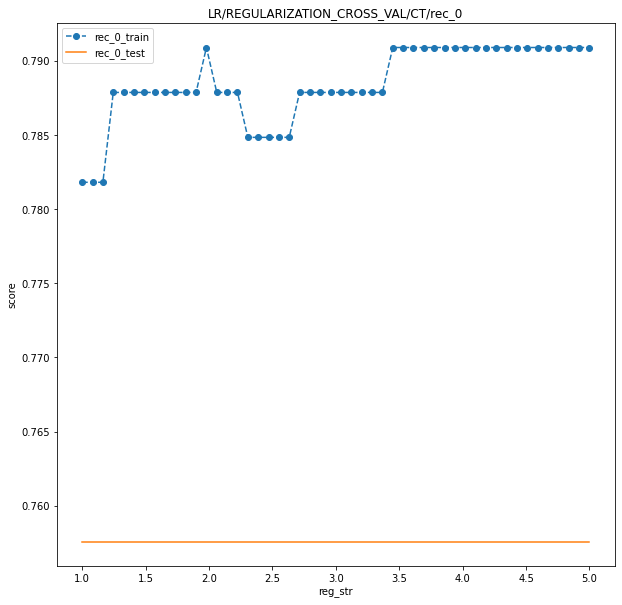

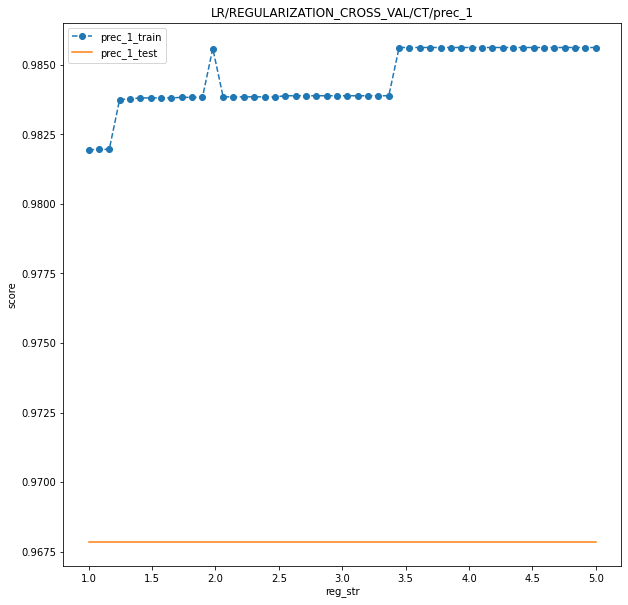

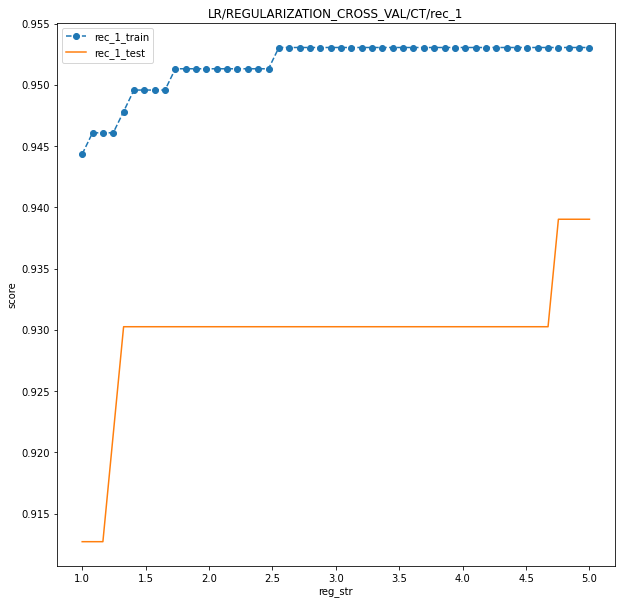

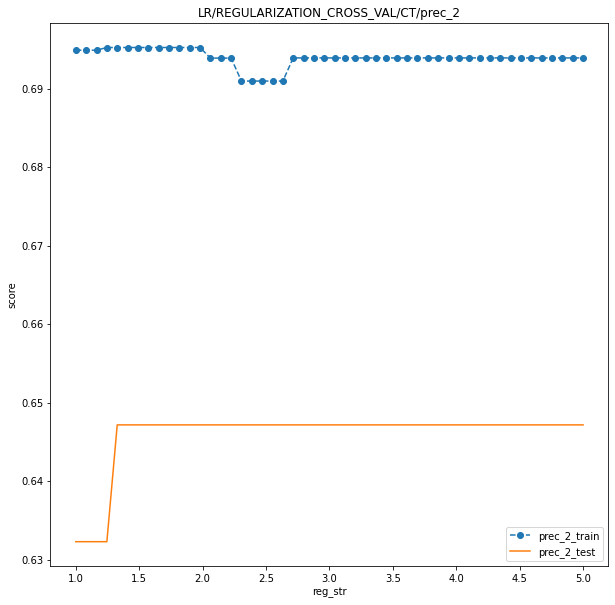

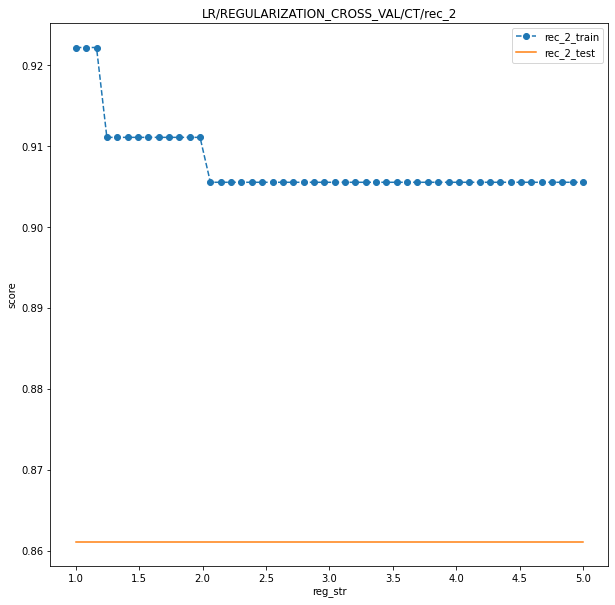

<Figure size 720x720 with 0 Axes>

In [251]:
plot(ct_new_result, np.linspace(1, 5, 50), list(scores.keys()),'LR/REGULARIZATION_CROSS_VAL/CT', 'reg_str', 'score', 'reg_str', 'logisticRegression','CT')

## reg strength of 5 seems like a good choice

In [252]:
new_ct_pipe = Pipeline([('transformer', create_column_transformer()),
                    ('model', LogisticRegression(class_weight = {0:1,1:1,2:2.75}, C = 5))])

In [254]:
new_ct_pipe.fit(x_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('standard', StandardScaler(),
                                                  ['pelvic_tilt',
                                                   'sacral_slope',
                                                   'pelvic_radius']),
                                                 ('robust', RobustScaler(),
                                                  ['pelvic_incidence',
                                                   'lumbar_lordosis_angle',
                                                   'degree_spondylolisthesis'])])),
                ('model',
                 LogisticRegression(C=5, class_weight={0: 1, 1: 1, 2: 2.75}))])

In [255]:
eval_score(y_train, new_ct_pipe.predict(x_train))

{'prec_0': 0.8813559322033898,
 'rec_0': 0.7878787878787878,
 'prec_1': 0.990990990990991,
 'rec_1': 0.9565217391304348,
 'prec_2': 0.6808510638297872,
 'rec_2': 0.8888888888888888}

In [256]:
eval_score(y_test, new_ct_pipe.predict(x_test))

{'prec_0': 0.7586206896551724,
 'rec_0': 0.6470588235294118,
 'prec_1': 0.9444444444444444,
 'rec_1': 0.9714285714285714,
 'prec_2': 0.6071428571428571,
 'rec_2': 0.7083333333333334}

### LogisticRegression with partial standard scaling and partial robust scaling performance

#### Normal Precision : 0.75
#### Normal Recall : 0.64
#### Spondylolisthesis Precision : 0.94
#### Spondylolisthesis Recall : 0.971
#### Disk Hernia Precision : 0.607
#### Disk Hernia Recall : 0.708

## Overall this model has performed the best

## This model is saved